In [1]:
import numpy as np 
import pandas as pd 
import dask.dataframe as ddf
import tensorflow as tf
import os
from os import environ
!mamba run -n tf_on_gpu pip install -q pyarrow

print (tf.test.gpu_device_name())


/device:GPU:0


2023-01-02 11:57:42.555607: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-02 11:57:42.715301: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-02 11:57:42.729757: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-02 11:57:42.731433: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, 

In [2]:
from feather_io import FeatherReader    

train_dataset = FeatherReader(environ.get("TRAIN_DATA", "covariance-train")).as_tf_dataset()
validation_dataset = FeatherReader(environ.get("VALIDATION_DATA", "covariance-validation")).as_tf_dataset()

2023-01-02 11:57:43.512891: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-02 11:57:43.514246: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-02 11:57:43.515479: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-02 11:57:43.517083: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-02 11:57:43.518398: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [3]:
X, y = next(iter(train_dataset.batch(1_000_000)))
y.shape

2023-01-02 11:57:43.822703: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


TensorShape([351956, 15])

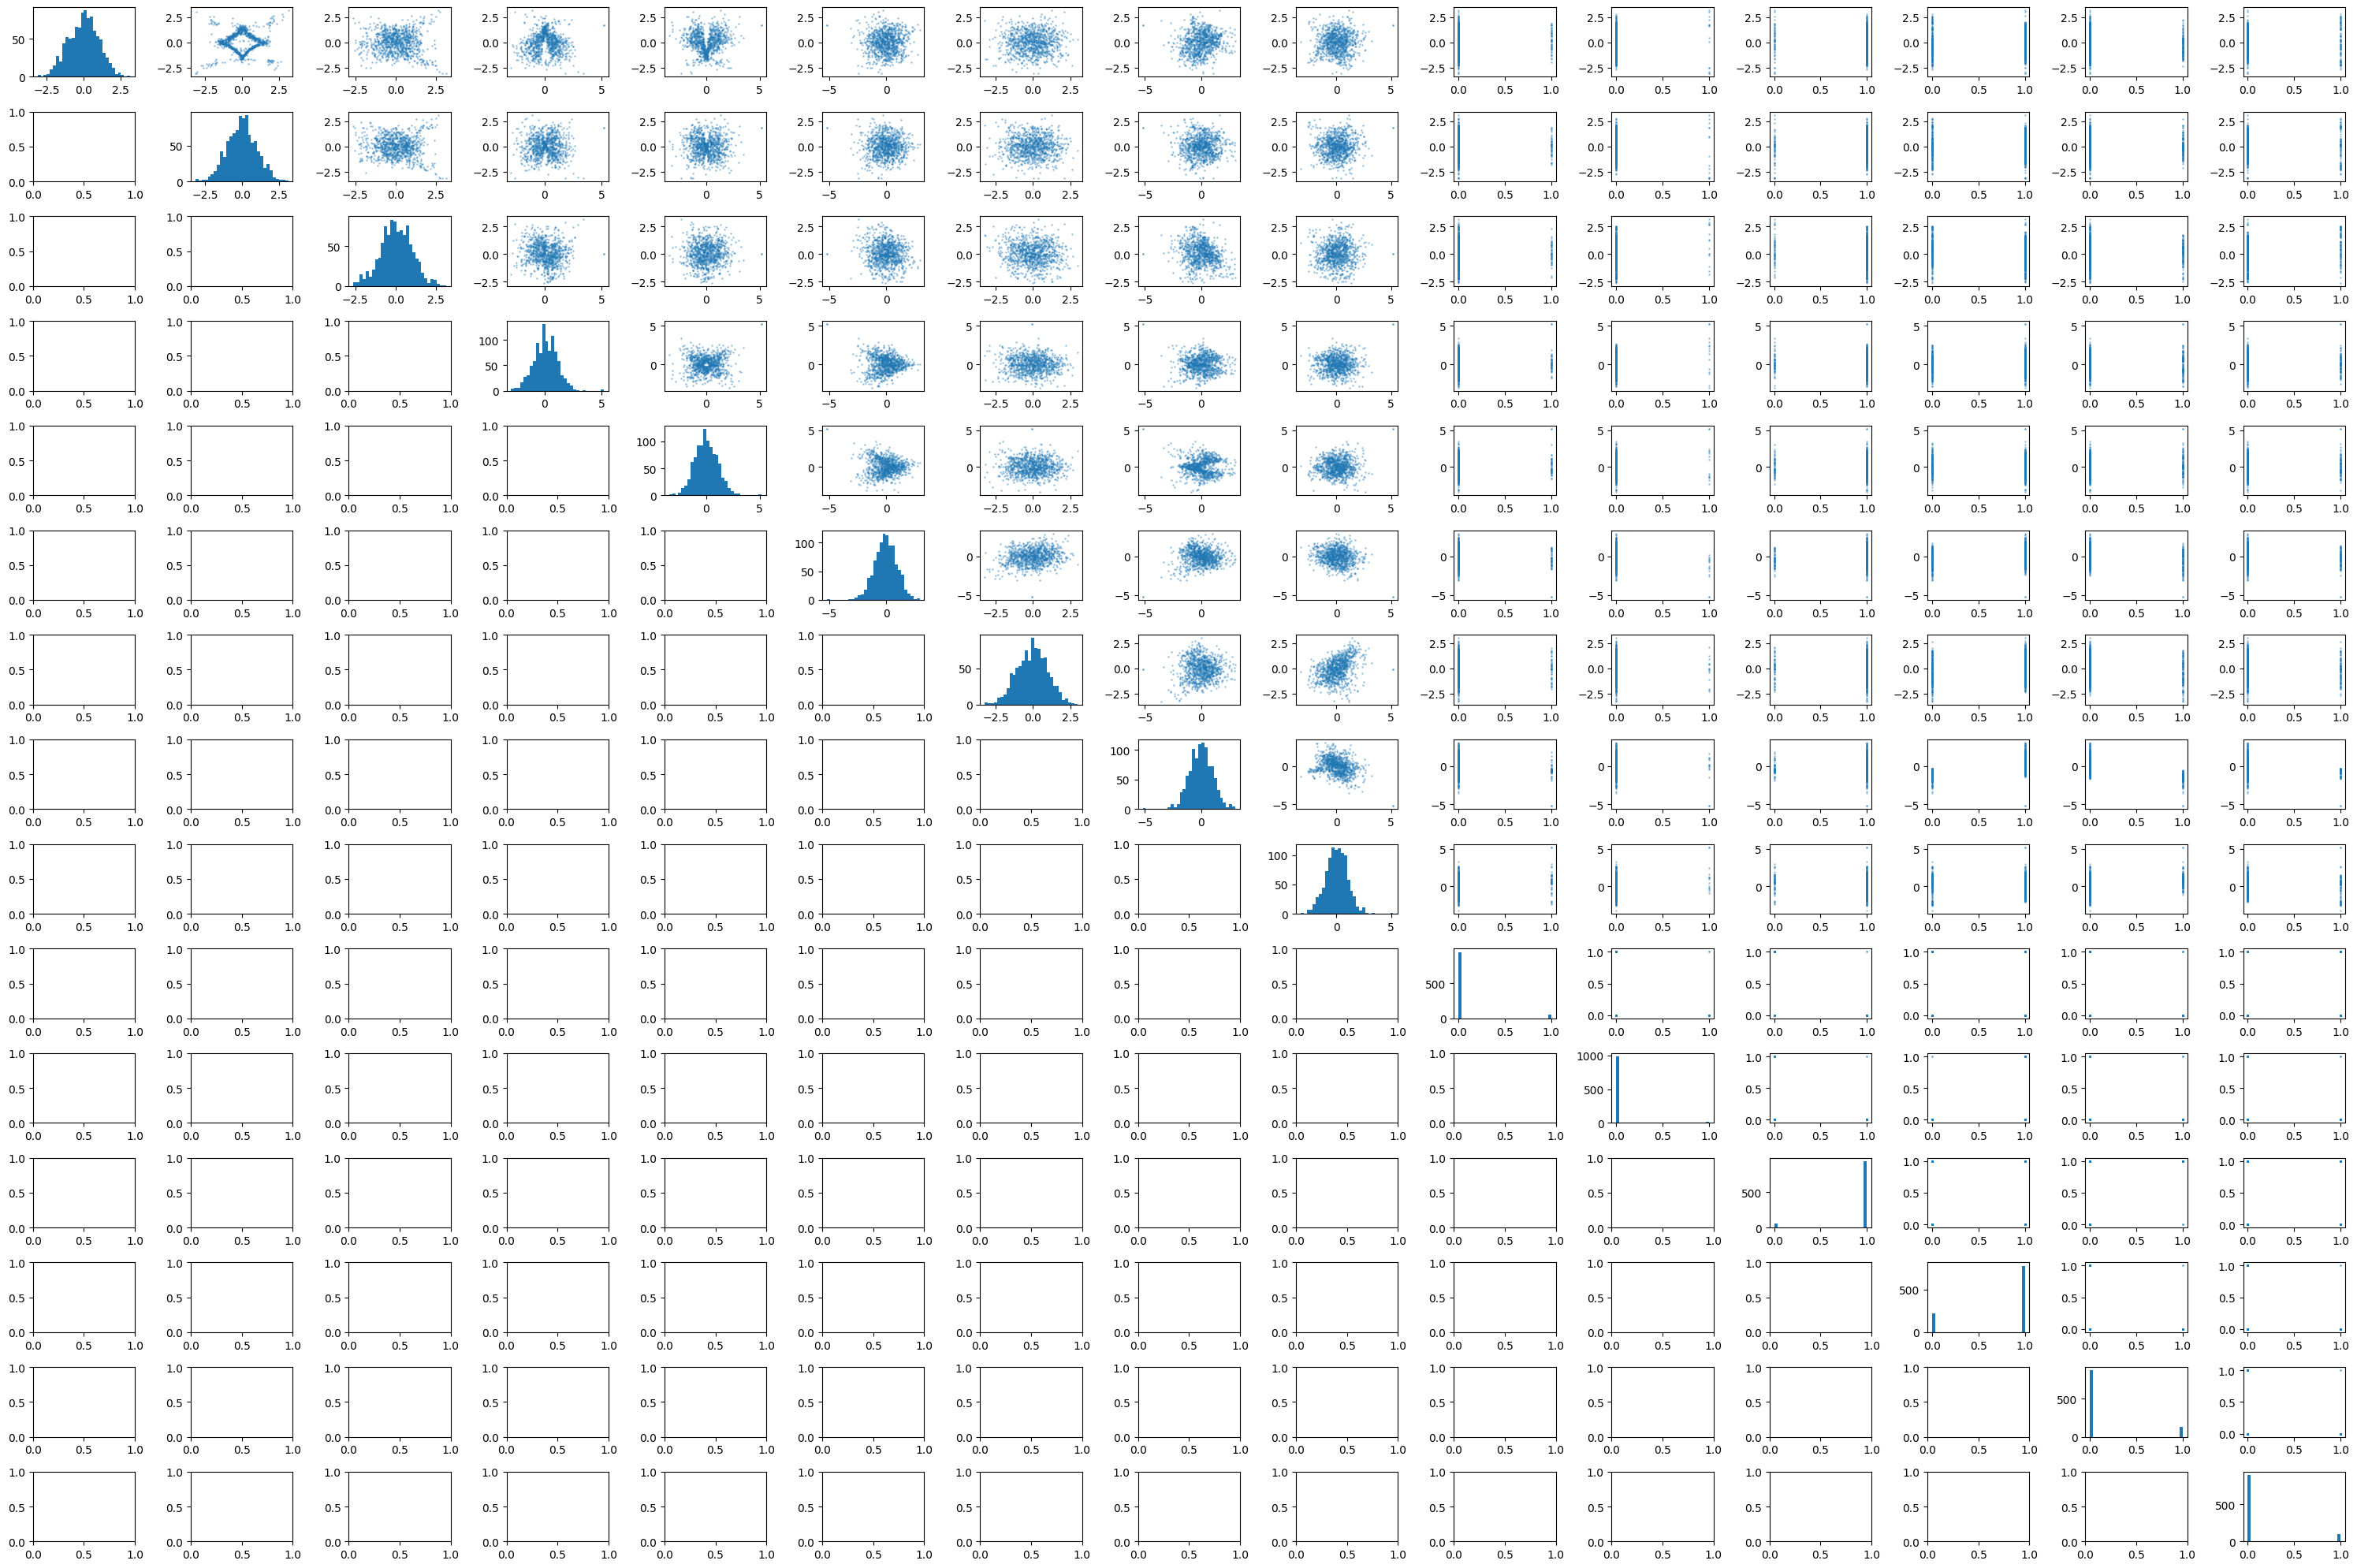

In [4]:
import matplotlib.pyplot as plt
X, y = next(iter(train_dataset.batch(1_000)))
X = X.numpy()

nX = X.shape[1]

plt.figure(figsize=(30,20))
for iVar, x_i in enumerate(X.T, 1):
    for jVar, x_j in enumerate(X.T, 1):
        plt.subplot(nX, nX, nX*(iVar-1) + jVar)
        if iVar == jVar:
            plt.hist(x_i, bins=30)
        elif iVar < jVar:
            plt.scatter(x_j, x_i, s=1, alpha=0.3)
plt.tight_layout()
        
plt.show()

In [5]:
g_nLayers = 8
d_nLayers = 6
r_nLayers = 6

In [6]:
g_input = tf.keras.layers.Input(shape=[X.shape[1]])
random = tf.keras.layers.Input(shape=[128])

g_dense_cfg=dict(units=128, activation='tanh', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L2(1e-3))

x = tf.keras.layers.Concatenate(axis=1)((g_input, random))
x = tf.keras.layers.Dense(**g_dense_cfg)(x)
for i in range(g_nLayers):
    x_ = tf.keras.layers.Dense(**g_dense_cfg)(x)
    x = x + x_

ny = y.shape[1]
output = tf.keras.layers.Dense(ny)(x) #+ random[:, :ny]
    
    
generator = tf.keras.Model(inputs=[g_input, random], outputs = output)
generator.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 15)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 143)          0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          18432       concatenate[0][0]            

In [7]:
d_input_ref_x = tf.keras.layers.Input(shape=[X.shape[1]], name="X_ref")

d_input_ref_y = tf.keras.layers.Input(shape=[y.shape[1]], name="Y_ref")
d_input_gen_y = tf.keras.layers.Input(shape=[y.shape[1]], name="Y_gen")

d_input_y = tf.keras.layers.Concatenate(axis=0, name="Y")((d_input_ref_y, d_input_gen_y))
d_input_x = tf.keras.layers.Concatenate(axis=0, name="X")((d_input_ref_x, d_input_ref_x))

d_input = tf.keras.layers.Concatenate(axis=1, name="XY")((d_input_x, d_input_y))

d_dense_cfg=dict(units=128, activation='tanh', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L2(1e-2))

x = tf.keras.layers.Dense(**d_dense_cfg)(d_input)
for i in range(d_nLayers):
    x = tf.keras.layers.Dense(**d_dense_cfg)(x)
    #x = x + x_

output = tf.keras.layers.Dense(1)(x)

discriminator = tf.keras.Model(inputs=[d_input_ref_x, d_input_ref_y, d_input_gen_y], outputs=[output])
discriminator.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X_ref (InputLayer)              [(None, 15)]         0                                            
__________________________________________________________________________________________________
Y_ref (InputLayer)              [(None, 15)]         0                                            
__________________________________________________________________________________________________
Y_gen (InputLayer)              [(None, 15)]         0                                            
__________________________________________________________________________________________________
X (Concatenate)                 (None, 15)           0           X_ref[0][0]                      
                                                                 X_ref[0][0]                

In [8]:
r_input_ref_x = tf.keras.layers.Input(shape=[X.shape[1]])

r_input_ref_y = tf.keras.layers.Input(shape=[y.shape[1]])
r_input_gen_y = tf.keras.layers.Input(shape=[y.shape[1]])

r_input_y = tf.keras.layers.Concatenate(axis=0)((r_input_ref_y, r_input_gen_y))
r_input_x = tf.keras.layers.Concatenate(axis=0)((r_input_ref_x, r_input_ref_x))

r_input = tf.keras.layers.Concatenate(axis=1)((r_input_x, r_input_y))

r_dense_cfg=d_dense_cfg

x = tf.keras.layers.Dense(**r_dense_cfg)(r_input)
for i in range(r_nLayers):
    x = tf.keras.layers.Dense(**r_dense_cfg)(x)
    #x = x + x_

output = tf.keras.layers.Dense(1)(x)

referee = tf.keras.Model(inputs=[r_input_ref_x, r_input_ref_y, r_input_gen_y], outputs=[output])
referee.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 15)]         0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 15)]         0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 15)]         0                                            
__________________________________________________________________________________________________
concatenate_2 (Concatenate)     (None, 15)           0           input_3[0][0]                    
                                                                 input_3[0][0]              

In [9]:
compute_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, label_smoothing=0.1)

class DelayedSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, stable_lr, warmup_steps): 
        super(DelayedSchedule, self).__init__()
        self._warmup_steps = warmup_steps
        self._stable_lr = stable_lr
        
    def __call__(self, step):
        return tf.where(step < self._warmup_steps, 0., self._stable_lr)
        
    


g_optimizer = tf.keras.optimizers.RMSprop(DelayedSchedule(2e-4, warmup_steps=500))
d_optimizer = tf.keras.optimizers.RMSprop(3e-4)
r_optimizer = tf.keras.optimizers.RMSprop(1e-3)

@tf.function
def train_step(dataset):
    X, y_ref = dataset
    batch_size = tf.shape(X)[0]
    label_true = tf.concat((tf.ones(batch_size), tf.zeros(batch_size)), axis=0)

    r = tf.random.normal([batch_size, random.shape[1]], 0., 1.)
    
    with tf.GradientTape(watch_accessed_variables=False) as tape_generator:
        with tf.GradientTape(watch_accessed_variables=False) as tape_discriminator:
            tape_generator.watch(generator.weights)
            tape_discriminator.watch(discriminator.weights)
            
            y_gen = generator((X, r))

            label_pred = discriminator((X, y_ref, y_gen))

            d_loss = compute_loss(label_true, label_pred)
            g_loss = -d_loss
            
    with tf.GradientTape() as tape_referee:
        tape_referee.watch(referee.weights)
        label_referee = referee((X, y_ref, y_gen))
        r_loss = compute_loss(label_true, label_referee)

    
    g_vars = generator.weights
    d_vars = discriminator.weights
    r_vars = referee.weights
    
    d_grads = tape_discriminator.gradient(d_loss, d_vars)
    g_grads = tape_generator.gradient(g_loss, g_vars)
    r_grads = tape_referee.gradient(r_loss, r_vars)
 
    #print (g_grads)
    g_optimizer.apply_gradients(zip(g_grads, g_vars))
        
    d_optimizer.apply_gradients(zip(d_grads, d_vars))
    r_optimizer.apply_gradients(zip(r_grads, r_vars))
    
    return r_loss

    

@tf.function
def test_step(dataset):
    X, y_ref = dataset
    batch_size = tf.shape(X)[0]
    r = tf.random.normal([batch_size, random.shape[1]], 0., 1.)
    
    y_gen = generator((X, r))

    label_pred = referee((X, y_ref, y_gen))
    label_true = tf.concat((tf.ones(batch_size), tf.zeros(batch_size)), axis=0)
    
    return compute_loss(label_true, label_pred)
    

In [10]:
from tqdm import trange, tqdm

losses = []
validation_loss = []

vdst = next(iter(validation_dataset.batch(100_000)))

progress_bar = trange(3000)

step = 0
start_generator_training_at_epoch = None

for epoch in progress_bar:
    epoch_losses = []
    for dset in train_dataset.batch(10_000):
        epoch_losses.append(train_step(dset))
        step += 1
        if step > g_optimizer.lr._warmup_steps and start_generator_training_at_epoch is None:
            start_generator_training_at_epoch = epoch
    losses.append(np.mean(epoch_losses))
    validation_loss.append(test_step(vdst))
    
    progress_bar.set_description(f"Training (validation) loss: {losses[-1]:.3f} ({validation_loss[-1]:.3f})")

Training (validation) loss: 0.330 (0.396): 100%|██████████| 1000/1000 [21:41<00:00,  1.30s/it]


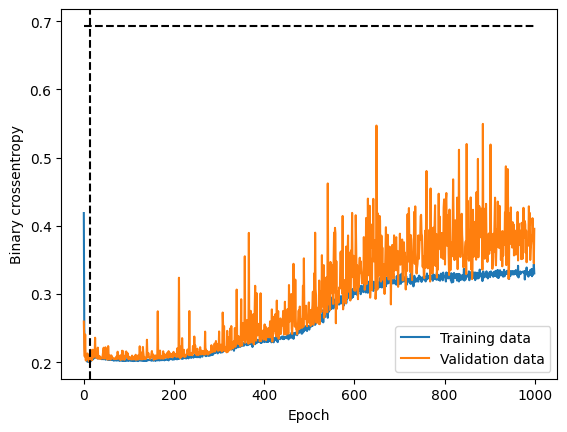

In [11]:
import matplotlib.pyplot as plt
plt.plot(losses, label="Training data")
plt.plot(validation_loss, label="Validation data")

plt.plot([0, len(losses)], [np.log(2)]*2, 'k--')
ylim = plt.ylim()
plt.plot([start_generator_training_at_epoch]*2, ylim, 'k--')
plt.ylim(ylim)

plt.xlabel("Epoch")


plt.ylabel("Binary crossentropy")
plt.legend()
plt.show()

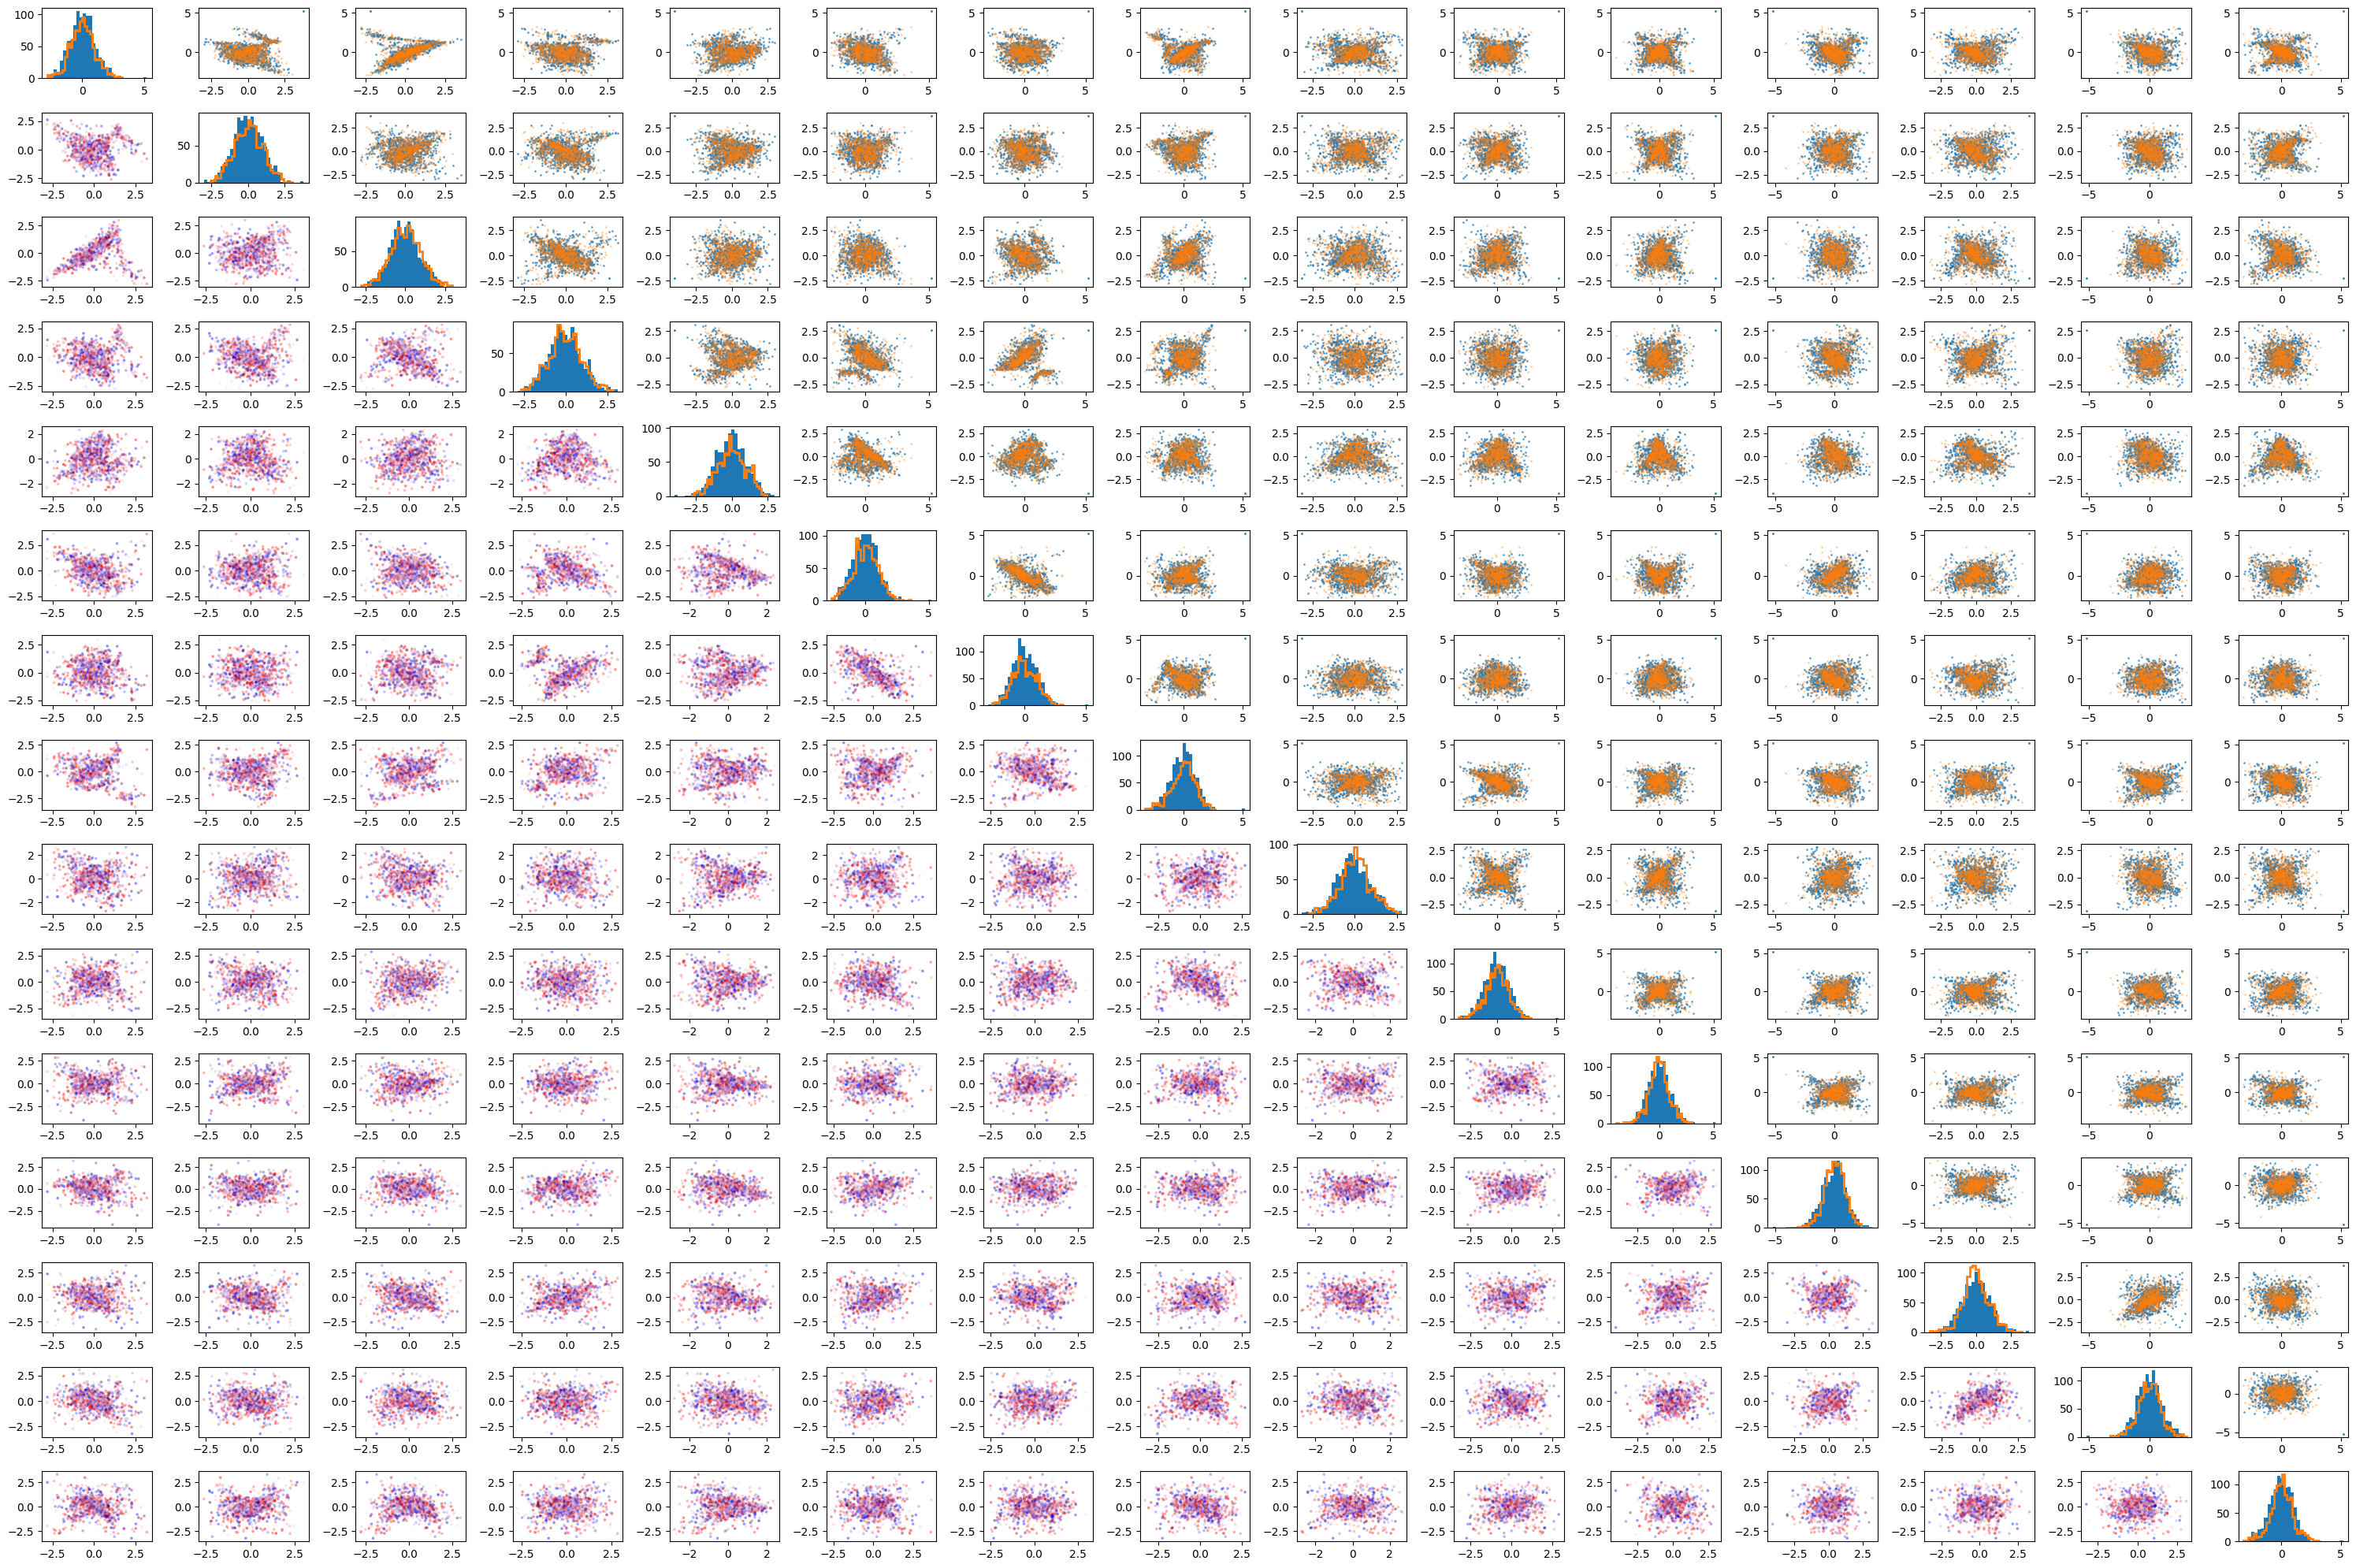

In [12]:
X, y = next(iter(train_dataset.batch(1_000)))
y = y.numpy()
y_hat = generator.predict((X, tf.random.normal((X.shape[0], 128))))
d = discriminator.predict((X, y, y_hat))


nY = y.shape[1]

plt.figure(figsize=(30,20))
for iVar, y_i in enumerate(y.T, 1):
    for jVar, y_j in enumerate(y.T, 1):
        plt.subplot(nY, nY, nX*(iVar-1) + jVar)
        if iVar == jVar:
            plt.hist(y_i, bins=30)
        elif iVar < jVar:
            plt.scatter(y_j, y_i, s=1, alpha=0.6)
            
            
for iVar, y_i in enumerate(y_hat.T, 1):
    for jVar, y_j in enumerate(y_hat.T, 1):
        plt.subplot(nY, nY, nX*(iVar-1) + jVar)
        if iVar == jVar:
            plt.hist(y_i, bins=30, histtype='step', linewidth=2)
        elif iVar < jVar:
            plt.scatter(y_j, y_i, s=1, alpha=0.3)
        elif iVar > jVar:
            
            plt.scatter(y_j, y_i, s=3, c=d[1000:], alpha=0.3, cmap='seismic')
        
plt.tight_layout()
        
plt.show()

In [13]:
cx, cy = np.meshgrid(np.linspace(-5, 5, 30), np.linspace(-5, 5, 30))
cx

array([[-5.        , -4.65517241, -4.31034483, -3.96551724, -3.62068966,
        -3.27586207, -2.93103448, -2.5862069 , -2.24137931, -1.89655172,
        -1.55172414, -1.20689655, -0.86206897, -0.51724138, -0.17241379,
         0.17241379,  0.51724138,  0.86206897,  1.20689655,  1.55172414,
         1.89655172,  2.24137931,  2.5862069 ,  2.93103448,  3.27586207,
         3.62068966,  3.96551724,  4.31034483,  4.65517241,  5.        ],
       [-5.        , -4.65517241, -4.31034483, -3.96551724, -3.62068966,
        -3.27586207, -2.93103448, -2.5862069 , -2.24137931, -1.89655172,
        -1.55172414, -1.20689655, -0.86206897, -0.51724138, -0.17241379,
         0.17241379,  0.51724138,  0.86206897,  1.20689655,  1.55172414,
         1.89655172,  2.24137931,  2.5862069 ,  2.93103448,  3.27586207,
         3.62068966,  3.96551724,  4.31034483,  4.65517241,  5.        ],
       [-5.        , -4.65517241, -4.31034483, -3.96551724, -3.62068966,
        -3.27586207, -2.93103448, -2.5862069 , -2

In [14]:
import os
default_output_model = "/workarea/cloud-storage/anderlinil/models/covariance"
output_model = os.path.dirname(environ['OUTPUT_MODEL']) if 'OUTPUT_MODEL' in environ else default_output_model
base_dir = os.path.dirname(output_model)
if not os.path.exists(base_dir):
    os.mkdir(base_dir)
generator.save(output_model)

2023-01-02 12:20:07.479872: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /workarea/cloud-storage/anderlinil/models/covariance/assets
